In [1]:
from utils import initialize_model, train_stepLR, train_cosine, perform_train
import gym
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize
import random
import torch.optim as optim
import torch.optim as optim
import csv

cuda


In [2]:
# Define the device for PyTorch computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
all_env = list(gym.envs.registry.keys())

print('Total Environments in Gym version {} : {}'.format(gym.__version__,len(all_env)))

Total Environments in Gym version 0.25.2 : 996


## Let's start the environment

In [4]:
#define environment
env = gym.make("AssaultDeterministic-v4", render_mode="rgb_array")

obs = env.reset()

# Inspect the observation
print("Observation shape:", obs.shape)
print("Observation dtype:", obs.dtype)

#Inspect action space
num_actions = env.action_space.n
print("Number of possible actions:", num_actions)

Observation shape: (210, 160, 3)
Observation dtype: uint8
Number of possible actions: 7


In [5]:
#Now we define the hyper parameters:
learning_rate = 0.0001
gamma = 0.99                      # Discount factor
epsilon = 1.0                     # Initial exploration rate
epsilon_decay = 0.995             # Epsilon decay rate
epsilon_min = 0.1                 # Minimum epsilon
replay_buffer_size = 100000       # Replay buffer size
batch_size = 1                  # Batch size for training
target_update_frequency = 1000    # Update target network after these many steps
max_episodes = 1000               # Maximum number of episodes
max_steps_per_episode = 10000     # Maximum steps per episode

Now we define the Q-Network based on the paper architecture

In [6]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        """
        Initialize the DQN network.
        
        :param input_shape: Tuple representing the input shape (channels, height, width).
        :param num_actions: Number of possible actions (output Q-values for each action).
        """
        super(DQN, self).__init__()
        
        # First convolutional layer: 32 filters of size 8x8 with stride 4
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=8, stride=4)
        
        # Second convolutional layer: 64 filters of size 4x4 with stride 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        
        # Third convolutional layer: 64 filters of size 3x3 with stride 1
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        
        # Calculate the flattened size after convolutions
        def conv_output_size(size, kernel_size, stride, padding=0):
            return (size - kernel_size + 2 * padding) // stride + 1

        conv_h = conv_output_size(
            conv_output_size(conv_output_size(input_shape[1], 8, 4), 4, 2), 3, 1
        )
        conv_w = conv_output_size(
            conv_output_size(conv_output_size(input_shape[2], 8, 4), 4, 2), 3, 1
        )
        linear_input_size = conv_h * conv_w * 64

        # Fully connected layer for output Q-values
        self.fc = nn.Linear(linear_input_size, num_actions)

    def forward(self, x):
        """
        Forward pass through the network.
        
        :param x: Input tensor of shape (batch_size, channels, height, width).
        :return: Tensor of shape (batch_size, num_actions) representing Q-values.
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.contiguous().view(x.size(0), -1)  # Flatten for the fully connected layer
        x = self.fc(x)
        return x

Pre processing the observation

In [7]:
def preprocess_observation(obs):
    """
    Preprocesses an Atari observation from (210, 160, 3) to (84, 84, 1) grayscale.

    :param obs: Raw observation from the environment (NumPy array of shape (210, 160, 3)).
    :return: Preprocessed observation (NumPy array of shape (84, 84, 1)).
    """
    # Convert to grayscale
    gray_obs = rgb2gray(obs)  # Shape: (210, 160)
    
    # Resize to 84x84
    resized_obs = resize(gray_obs, (84, 84), anti_aliasing=True)  # Shape: (84, 84)
    
    # Normalize pixel values to [0, 1]
    normalized_obs = resized_obs / 255.0
    
    # Add a channel dimension to make it (84, 84, 1)
    #preprocessed_obs = np.expand_dims(normalized_obs, axis=-1)
    
    return normalized_obs

In [8]:

class ReplayBuffer:
    def __init__(self, capacity):
        """
        Initialize the replay buffer.

        :param capacity: Maximum number of transitions the buffer can hold.
        """
        self.capacity = capacity
        self.buffer = []
        self.position = 0  # Tracks the next position to overwrite when the buffer is full

    def store(self, state, action, reward, next_state, done):
        """
        Store a transition in the replay buffer.

        :param state: Current state (preprocessed).
        :param action: Action taken.
        :param reward: Reward received.
        :param next_state: Next state (preprocessed).
        :param done: Whether the episode is done.
        """
        # Create a tuple for the transition
        transition = (state, action, reward, next_state, done)

        # If the buffer isn't full, add the transition
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
        else:
            # Overwrite the oldest transition
            self.buffer[self.position] = transition

        # Update the position to overwrite
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
    
        return random.sample(self.buffer, batch_size)
    
    

    def size(self):

        return len(self.buffer)

In [9]:
class DQNAgent:
    def __init__(self, env, replay_buffer, input_shape, num_actions, batch_size=32, gamma=0.99, lr=0.0001, target_update_frequency=1000, n_frames=1):
        """
        Initialize the DQN agent.

        :param env: The Gym environment.
        :param replay_buffer: ReplayBuffer instance for experience storage.
        :param input_shape: Shape of the input state (e.g., (1, 84, 84)).
        :param num_actions: Number of possible actions in the environment.
        :param batch_size: Batch size for training.
        :param gamma: Discount factor for future rewards.
        :param lr: Learning rate for the optimizer.
        :param target_update_frequency: Steps between target network updates.
        """
        self.env = env
        self.replay_buffer = replay_buffer
        self.batch_size = batch_size
        self.gamma = gamma
        self.target_update_frequency = target_update_frequency
        self.num_actions = num_actions
        self.n_frames = n_frames

        # Q-network and target network
        self.q_network = DQN(input_shape, num_actions).to(device)
        self.target_network = DQN(input_shape, num_actions).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())  # Initialize with same weights
        self.target_network.eval()  # Target network doesn't train

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

        # Epsilon-greedy parameters
        self.epsilon = 1.0  # Start with full exploration
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.1

        # Training step counter
        self.step_count = 0
        
        # Initialize the frame stack
        self.frame_stack = []
        
    
    def reset_frame_stack(self):
        """Reset the frame stack."""
        initial_frame = preprocess_observation(self.env.reset()) 
        self.frame_stack = [initial_frame] * self.n_frames  # Duplicate the first frame

    def stack_frames(self, new_frame):
        """Update the frame stack with a new frame."""
        self.frame_stack.pop(0)  # Remove the oldest frame
        self.frame_stack.append(new_frame)  # Add the new frame
        
        return np.stack(self.frame_stack, axis=0)

    def select_action(self, stacked_state):
        """
        Select an action using epsilon-greedy policy.

        :param state: Current state of the environment.
        :return: Chosen action.
        """
        
        #state = self.stack_frames(state)
        
        if random.random() < self.epsilon:
            return self.env.action_space.sample()  # Explore: random action
        else:
            state_tensor = torch.tensor(stacked_state, dtype=torch.float32).unsqueeze(0).to(device)
            #state_tensor = state_tensor.permute(0, 3, 1, 2) 
            #print("after permute state_tensor", state_tensor.size())
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item()  # Exploit: max Q-value action
        

    def train_step(self):
        """
        Perform one training step.
        """
        if self.replay_buffer.size() < self.batch_size:
            return  # Not enough data to train
        
        # Sample a batch from the replay buffer
        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Sample a batch from the replay buffer
        #single_transition = replay_buffer.sample(batch_size=1)[0]  
        #state, action, reward, next_state, done = single_transition

        # Convert to tensors
        states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.int64).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)

        # Compute current Q-values
        #print("Initial state print before permutation ", states.shape)
        #states = states.permute(0, 3, 1, 2)  
        #print("Initial state print after permutation ", states.shape)
        
        q_values = self.q_network(states)
        #print("Q_values size", q_values.size())
        #actions = actions.unsqueeze(0) 
        #print("action size", actions.size())
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        
        #formating for the network
        #print("next state before permutation ", next_states.size())

        # Compute target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute loss and backpropagate
        loss = torch.nn.functional.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.step_count += 1
        if self.step_count % self.target_update_frequency == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

        return loss.item()

In [10]:
def train_dqn(agent, num_episodes, max_steps_per_episode, csv_filename):
    """
    Train the DQN agent.

    :param agent: The DQNAgent instance.
    :param num_episodes: Number of episodes to train.
    :param max_steps_per_episode: Maximum steps per episode.
    """
    
    # Initialize the CSV file with a header
    with open(csv_filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["episode", "total_reward", "loss", "epsilon"])  # Write the header row
        
        
    for episode in range(num_episodes):
        
        # Start the stacked frames
        agent.reset_frame_stack()
        agent_reset= agent.env.reset()
        #print(agent_reset.shape)
        initial_frame = preprocess_observation(agent_reset) # Preprocess the initial observation
        #print("Initial frame ", initial_frame.shape)
        state = agent.stack_frames(initial_frame)  
        
        
        total_reward = 0
        loss = 0

        for step in range(max_steps_per_episode):
            # Select an action using the epsilon-greedy policy
            action = agent.select_action(state)
            
            # Take the action in the environment
            next_frame, reward, done, _ = agent.env.step(action)
            next_frame = preprocess_observation(next_frame)
            #print("frame ", next_frame.shape)

            # Update the frame stack with the new frame
            next_state = agent.stack_frames(next_frame)
            #print(next_state.shape)

            # Store the transition in the replay buffer
            agent.replay_buffer.store(state, action, reward, next_state, done)

            # Train the network
            loss = agent.train_step()

            # Update total reward
            total_reward += reward

            # Update the current state
            state = next_state

            # Break the loop if the episode is done
            if done:
                break

        # Decay epsilon
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        
         # Save results to CSV
        with open(csv_filename, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([episode + 1, total_reward, loss, agent.epsilon])  # Append the row

        print(f"Episode {episode + 1}/{num_episodes} - Reward: {total_reward:.2f}, Loss: {loss:.4f}, Epsilon: {agent.epsilon:.4f}")

        
    print(f"Training results saved to {csv_filename}")

In [11]:
replay_buffer = ReplayBuffer(capacity=100)
csv_filename = "dqn_results_4frames.csv"
n_frames = 4

# Initialize agent
input_shape = (n_frames, 84, 84)  # 4 stacked frames
num_actions = env.action_space.n
agent = DQNAgent(env, replay_buffer, input_shape, num_actions, n_frames=n_frames)

# Train the agent
num_episodes = 1000
max_steps_per_episode = 10000
train_dqn(agent, num_episodes, max_steps_per_episode, csv_filename=csv_filename)

# Evaluate the agent
#evaluate_agent(agent, num_episodes=10, max_steps_per_episode=10000)

Episode 1/1000 - Reward: 252.00, Loss: 0.0226, Epsilon: 0.9950
Episode 2/1000 - Reward: 336.00, Loss: 0.7389, Epsilon: 0.9900
Episode 3/1000 - Reward: 315.00, Loss: 26.2486, Epsilon: 0.9851
Episode 4/1000 - Reward: 378.00, Loss: 12.5557, Epsilon: 0.9801
Episode 5/1000 - Reward: 189.00, Loss: 0.2040, Epsilon: 0.9752
Episode 6/1000 - Reward: 273.00, Loss: 1.2157, Epsilon: 0.9704
Episode 7/1000 - Reward: 231.00, Loss: 0.6470, Epsilon: 0.9655
Episode 8/1000 - Reward: 294.00, Loss: 0.4078, Epsilon: 0.9607
Episode 9/1000 - Reward: 315.00, Loss: 28.3456, Epsilon: 0.9559
Episode 10/1000 - Reward: 168.00, Loss: 0.5272, Epsilon: 0.9511
Episode 11/1000 - Reward: 252.00, Loss: 0.1713, Epsilon: 0.9464
Episode 12/1000 - Reward: 252.00, Loss: 4.4472, Epsilon: 0.9416
Episode 13/1000 - Reward: 252.00, Loss: 24.5853, Epsilon: 0.9369
Episode 14/1000 - Reward: 189.00, Loss: 12.6395, Epsilon: 0.9322
Episode 15/1000 - Reward: 378.00, Loss: 1.1828, Epsilon: 0.9276
Episode 16/1000 - Reward: 105.00, Loss: 0.66

Episode 128/1000 - Reward: 336.00, Loss: 2.3163, Epsilon: 0.5264
Episode 129/1000 - Reward: 189.00, Loss: 0.0004, Epsilon: 0.5238
Episode 130/1000 - Reward: 210.00, Loss: 0.3527, Epsilon: 0.5212
Episode 131/1000 - Reward: 231.00, Loss: 0.0021, Epsilon: 0.5186
Episode 132/1000 - Reward: 210.00, Loss: 0.4106, Epsilon: 0.5160
Episode 133/1000 - Reward: 210.00, Loss: 96.3132, Epsilon: 0.5134
Episode 134/1000 - Reward: 294.00, Loss: 0.0604, Epsilon: 0.5108
Episode 135/1000 - Reward: 315.00, Loss: 24.9169, Epsilon: 0.5083
Episode 136/1000 - Reward: 105.00, Loss: 0.8320, Epsilon: 0.5058
Episode 137/1000 - Reward: 168.00, Loss: 13.3307, Epsilon: 0.5032
Episode 138/1000 - Reward: 189.00, Loss: 94.9238, Epsilon: 0.5007
Episode 139/1000 - Reward: 273.00, Loss: 0.2478, Epsilon: 0.4982
Episode 140/1000 - Reward: 126.00, Loss: 106.2556, Epsilon: 0.4957
Episode 141/1000 - Reward: 357.00, Loss: 107.5411, Epsilon: 0.4932
Episode 142/1000 - Reward: 189.00, Loss: 120.2319, Epsilon: 0.4908
Episode 143/100

Episode 253/1000 - Reward: 210.00, Loss: 127.9171, Epsilon: 0.2813
Episode 254/1000 - Reward: 189.00, Loss: 0.0003, Epsilon: 0.2799
Episode 255/1000 - Reward: 399.00, Loss: 13.2432, Epsilon: 0.2785
Episode 256/1000 - Reward: 210.00, Loss: 2.5745, Epsilon: 0.2771
Episode 257/1000 - Reward: 294.00, Loss: 0.3836, Epsilon: 0.2758
Episode 258/1000 - Reward: 210.00, Loss: 0.1956, Epsilon: 0.2744
Episode 259/1000 - Reward: 189.00, Loss: 127.7354, Epsilon: 0.2730
Episode 260/1000 - Reward: 399.00, Loss: 0.0120, Epsilon: 0.2716
Episode 261/1000 - Reward: 63.00, Loss: 124.5423, Epsilon: 0.2703
Episode 262/1000 - Reward: 189.00, Loss: 123.1010, Epsilon: 0.2689
Episode 263/1000 - Reward: 189.00, Loss: 0.0004, Epsilon: 0.2676
Episode 264/1000 - Reward: 378.00, Loss: 0.0054, Epsilon: 0.2663
Episode 265/1000 - Reward: 42.00, Loss: 125.7565, Epsilon: 0.2649
Episode 266/1000 - Reward: 315.00, Loss: 36.1307, Epsilon: 0.2636
Episode 267/1000 - Reward: 84.00, Loss: 118.0547, Epsilon: 0.2623
Episode 268/10

Episode 378/1000 - Reward: 252.00, Loss: 12.9293, Epsilon: 0.1504
Episode 379/1000 - Reward: 252.00, Loss: 88.4058, Epsilon: 0.1496
Episode 380/1000 - Reward: 231.00, Loss: 87.4018, Epsilon: 0.1489
Episode 381/1000 - Reward: 420.00, Loss: 25.7714, Epsilon: 0.1481
Episode 382/1000 - Reward: 504.00, Loss: 0.0723, Epsilon: 0.1474
Episode 383/1000 - Reward: 357.00, Loss: 0.0438, Epsilon: 0.1466
Episode 384/1000 - Reward: 189.00, Loss: 41.7829, Epsilon: 0.1459
Episode 385/1000 - Reward: 210.00, Loss: 13.5667, Epsilon: 0.1452
Episode 386/1000 - Reward: 399.00, Loss: 13.5686, Epsilon: 0.1444
Episode 387/1000 - Reward: 420.00, Loss: 114.6870, Epsilon: 0.1437
Episode 388/1000 - Reward: 483.00, Loss: 13.0989, Epsilon: 0.1430
Episode 389/1000 - Reward: 63.00, Loss: 13.0089, Epsilon: 0.1423
Episode 390/1000 - Reward: 336.00, Loss: 0.0056, Epsilon: 0.1416
Episode 391/1000 - Reward: 147.00, Loss: 25.9868, Epsilon: 0.1409
Episode 392/1000 - Reward: 399.00, Loss: 89.3924, Epsilon: 0.1402
Episode 393/1

Episode 504/1000 - Reward: 315.00, Loss: 14.4665, Epsilon: 0.1000
Episode 505/1000 - Reward: 294.00, Loss: 39.5972, Epsilon: 0.1000
Episode 506/1000 - Reward: 399.00, Loss: 0.3898, Epsilon: 0.1000
Episode 507/1000 - Reward: 441.00, Loss: 12.7505, Epsilon: 0.1000
Episode 508/1000 - Reward: 252.00, Loss: 80.7979, Epsilon: 0.1000
Episode 509/1000 - Reward: 294.00, Loss: 77.9085, Epsilon: 0.1000
Episode 510/1000 - Reward: 273.00, Loss: 73.3946, Epsilon: 0.1000
Episode 511/1000 - Reward: 399.00, Loss: 8.7557, Epsilon: 0.1000
Episode 512/1000 - Reward: 210.00, Loss: 0.4286, Epsilon: 0.1000
Episode 513/1000 - Reward: 336.00, Loss: 0.9401, Epsilon: 0.1000
Episode 514/1000 - Reward: 252.00, Loss: 1.1690, Epsilon: 0.1000
Episode 515/1000 - Reward: 273.00, Loss: 0.4021, Epsilon: 0.1000
Episode 516/1000 - Reward: 189.00, Loss: 83.9001, Epsilon: 0.1000
Episode 517/1000 - Reward: 399.00, Loss: 83.7269, Epsilon: 0.1000
Episode 518/1000 - Reward: 441.00, Loss: 22.5005, Epsilon: 0.1000
Episode 519/1000

Episode 629/1000 - Reward: 21.00, Loss: 135.7430, Epsilon: 0.1000
Episode 630/1000 - Reward: 462.00, Loss: 47.8810, Epsilon: 0.1000
Episode 631/1000 - Reward: 399.00, Loss: 190.0806, Epsilon: 0.1000
Episode 632/1000 - Reward: 315.00, Loss: 70.1785, Epsilon: 0.1000
Episode 633/1000 - Reward: 189.00, Loss: 83.1631, Epsilon: 0.1000
Episode 634/1000 - Reward: 441.00, Loss: 96.9049, Epsilon: 0.1000
Episode 635/1000 - Reward: 483.00, Loss: 33.6430, Epsilon: 0.1000
Episode 636/1000 - Reward: 483.00, Loss: 22.6144, Epsilon: 0.1000
Episode 637/1000 - Reward: 378.00, Loss: 10.2439, Epsilon: 0.1000
Episode 638/1000 - Reward: 441.00, Loss: 111.4553, Epsilon: 0.1000
Episode 639/1000 - Reward: 105.00, Loss: 5.8700, Epsilon: 0.1000
Episode 640/1000 - Reward: 378.00, Loss: 22.1483, Epsilon: 0.1000
Episode 641/1000 - Reward: 336.00, Loss: 21.9399, Epsilon: 0.1000
Episode 642/1000 - Reward: 126.00, Loss: 86.5843, Epsilon: 0.1000
Episode 643/1000 - Reward: 294.00, Loss: 19.5130, Epsilon: 0.1000
Episode 6

Episode 754/1000 - Reward: 210.00, Loss: 7.0606, Epsilon: 0.1000
Episode 755/1000 - Reward: 168.00, Loss: 117.8080, Epsilon: 0.1000
Episode 756/1000 - Reward: 189.00, Loss: 71.7805, Epsilon: 0.1000
Episode 757/1000 - Reward: 231.00, Loss: 18.7608, Epsilon: 0.1000
Episode 758/1000 - Reward: 210.00, Loss: 68.0993, Epsilon: 0.1000
Episode 759/1000 - Reward: 525.00, Loss: 112.3286, Epsilon: 0.1000
Episode 760/1000 - Reward: 294.00, Loss: 3.4064, Epsilon: 0.1000
Episode 761/1000 - Reward: 189.00, Loss: 4.4734, Epsilon: 0.1000
Episode 762/1000 - Reward: 252.00, Loss: 89.7439, Epsilon: 0.1000
Episode 763/1000 - Reward: 210.00, Loss: 92.6643, Epsilon: 0.1000
Episode 764/1000 - Reward: 126.00, Loss: 10.1619, Epsilon: 0.1000
Episode 765/1000 - Reward: 105.00, Loss: 9.5789, Epsilon: 0.1000
Episode 766/1000 - Reward: 63.00, Loss: 48.3182, Epsilon: 0.1000
Episode 767/1000 - Reward: 273.00, Loss: 49.6749, Epsilon: 0.1000
Episode 768/1000 - Reward: 357.00, Loss: 14.1887, Epsilon: 0.1000
Episode 769/1

Episode 879/1000 - Reward: 168.00, Loss: 1.4130, Epsilon: 0.1000
Episode 880/1000 - Reward: 168.00, Loss: 1.2829, Epsilon: 0.1000
Episode 881/1000 - Reward: 189.00, Loss: 3.4437, Epsilon: 0.1000
Episode 882/1000 - Reward: 105.00, Loss: 6.2863, Epsilon: 0.1000
Episode 883/1000 - Reward: 63.00, Loss: 4.4380, Epsilon: 0.1000
Episode 884/1000 - Reward: 399.00, Loss: 16.4683, Epsilon: 0.1000
Episode 885/1000 - Reward: 294.00, Loss: 31.8881, Epsilon: 0.1000
Episode 886/1000 - Reward: 399.00, Loss: 33.4490, Epsilon: 0.1000
Episode 887/1000 - Reward: 252.00, Loss: 64.7047, Epsilon: 0.1000
Episode 888/1000 - Reward: 210.00, Loss: 40.0491, Epsilon: 0.1000
Episode 889/1000 - Reward: 378.00, Loss: 43.4046, Epsilon: 0.1000
Episode 890/1000 - Reward: 189.00, Loss: 1.4173, Epsilon: 0.1000
Episode 891/1000 - Reward: 84.00, Loss: 29.0616, Epsilon: 0.1000
Episode 892/1000 - Reward: 294.00, Loss: 21.7857, Epsilon: 0.1000
Episode 893/1000 - Reward: 378.00, Loss: 12.3447, Epsilon: 0.1000
Episode 894/1000 -

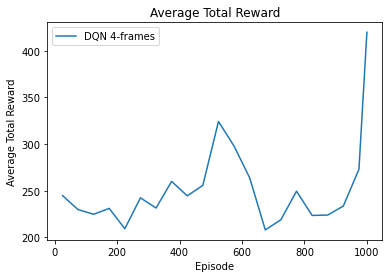

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV results
df = pd.read_csv("dqn_results_4frames.csv")

# Compute averages of total rewards every 50 episodes
df["group"] = df["episode"] // 50  # Group by every 50 episodes
average_rewards = df.groupby("group")["total_reward"].mean()  # Average rewards
average_episodes = df.groupby("group")["episode"].mean()  # Midpoint for episodes

# Plot the average total rewards over grouped episodes
plt.plot(average_episodes, average_rewards, label="DQN 4-frames")
plt.xlabel("Episode")
plt.ylabel("Average Total Reward")
plt.title("Average Total Reward")
plt.legend()
plt.show()

In [12]:
def evaluate_agent(agent, num_episodes, max_steps_per_episode):
    """
    Evaluate the DQN agent with stacked frames.

    :param agent: The DQNAgent instance.
    :param num_episodes: Number of evaluation episodes.
    :param max_steps_per_episode: Maximum steps per episode.
    """
    agent.epsilon = 0.0  # Turn off exploration
    total_rewards = []

    for episode in range(num_episodes):
        # Reset the environment and initialize the frame stack
        agent.reset_frame_stack()
        initial_frame = preprocess_observation(agent.env.reset())
        state = agent.stack_frames(initial_frame)  # Initialize the stacked state

        total_reward = 0

        for step in range(max_steps_per_episode):
            # Select the best action
            action = agent.select_action(state)

            # Take the action in the environment
            next_frame, reward, done, _ = agent.env.step(action)
            next_frame = preprocess_observation(next_frame)

            # Update the frame stack with the new frame
            state = agent.stack_frames(next_frame)

            # Update the total reward
            total_reward += reward

            if done:
                break

        total_rewards.append(total_reward)
        print(f"Evaluation Episode {episode + 1}/{num_episodes} - Reward: {total_reward:.2f}")

    print(f"Average Reward over {num_episodes} Episodes: {np.mean(total_rewards):.2f}")

    



In [13]:
evaluate_agent(agent, num_episodes=10, max_steps_per_episode=10000)

NameError: name 'agent' is not defined

Now lets try for 10 frames

In [14]:
replay_buffer_10 = ReplayBuffer(capacity=100)
csv_filename = "dqn_results_10frames.csv"
n_frames = 10

# Initialize agent
input_shape = (n_frames, 84, 84)  # 4 stacked frames
num_actions = env.action_space.n
agent_10 = DQNAgent(env, replay_buffer_10, input_shape, num_actions, n_frames=n_frames)

# Train the agent
num_episodes = 1000
max_steps_per_episode = 10000
train_dqn(agent_10, num_episodes, max_steps_per_episode, csv_filename=csv_filename)

Episode 1/1000 - Reward: 231.00, Loss: 0.2417, Epsilon: 0.9950
Episode 2/1000 - Reward: 126.00, Loss: 0.3197, Epsilon: 0.9900
Episode 3/1000 - Reward: 189.00, Loss: 0.0953, Epsilon: 0.9851
Episode 4/1000 - Reward: 273.00, Loss: 2.5154, Epsilon: 0.9801
Episode 5/1000 - Reward: 336.00, Loss: 0.2347, Epsilon: 0.9752
Episode 6/1000 - Reward: 189.00, Loss: 0.1571, Epsilon: 0.9704
Episode 7/1000 - Reward: 210.00, Loss: 0.3356, Epsilon: 0.9655
Episode 8/1000 - Reward: 252.00, Loss: 0.5376, Epsilon: 0.9607
Episode 9/1000 - Reward: 168.00, Loss: 13.0057, Epsilon: 0.9559
Episode 10/1000 - Reward: 315.00, Loss: 0.6320, Epsilon: 0.9511
Episode 11/1000 - Reward: 252.00, Loss: 1.8194, Epsilon: 0.9464
Episode 12/1000 - Reward: 189.00, Loss: 2.3378, Epsilon: 0.9416
Episode 13/1000 - Reward: 189.00, Loss: 0.0023, Epsilon: 0.9369
Episode 14/1000 - Reward: 252.00, Loss: 2.4370, Epsilon: 0.9322
Episode 15/1000 - Reward: 378.00, Loss: 25.0592, Epsilon: 0.9276
Episode 16/1000 - Reward: 147.00, Loss: 0.1282,

Episode 128/1000 - Reward: 252.00, Loss: 2.1758, Epsilon: 0.5264
Episode 129/1000 - Reward: 462.00, Loss: 0.1587, Epsilon: 0.5238
Episode 130/1000 - Reward: 189.00, Loss: 0.0028, Epsilon: 0.5212
Episode 131/1000 - Reward: 168.00, Loss: 136.4133, Epsilon: 0.5186
Episode 132/1000 - Reward: 105.00, Loss: 8.2664, Epsilon: 0.5160
Episode 133/1000 - Reward: 168.00, Loss: 2.0578, Epsilon: 0.5134
Episode 134/1000 - Reward: 189.00, Loss: 121.2275, Epsilon: 0.5108
Episode 135/1000 - Reward: 189.00, Loss: 134.4692, Epsilon: 0.5083
Episode 136/1000 - Reward: 189.00, Loss: 112.9286, Epsilon: 0.5058
Episode 137/1000 - Reward: 210.00, Loss: 170.0533, Epsilon: 0.5032
Episode 138/1000 - Reward: 231.00, Loss: 13.5311, Epsilon: 0.5007
Episode 139/1000 - Reward: 189.00, Loss: 139.4896, Epsilon: 0.4982
Episode 140/1000 - Reward: 378.00, Loss: 0.2483, Epsilon: 0.4957
Episode 141/1000 - Reward: 189.00, Loss: 0.0155, Epsilon: 0.4932
Episode 142/1000 - Reward: 399.00, Loss: 25.1404, Epsilon: 0.4908
Episode 143

Episode 253/1000 - Reward: 189.00, Loss: 0.0411, Epsilon: 0.2813
Episode 254/1000 - Reward: 336.00, Loss: 0.8511, Epsilon: 0.2799
Episode 255/1000 - Reward: 189.00, Loss: 0.4480, Epsilon: 0.2785
Episode 256/1000 - Reward: 189.00, Loss: 10.7451, Epsilon: 0.2771
Episode 257/1000 - Reward: 231.00, Loss: 0.0069, Epsilon: 0.2758
Episode 258/1000 - Reward: 231.00, Loss: 129.1548, Epsilon: 0.2744
Episode 259/1000 - Reward: 147.00, Loss: 0.3780, Epsilon: 0.2730
Episode 260/1000 - Reward: 273.00, Loss: 136.1180, Epsilon: 0.2716
Episode 261/1000 - Reward: 378.00, Loss: 0.0249, Epsilon: 0.2703
Episode 262/1000 - Reward: 231.00, Loss: 133.0237, Epsilon: 0.2689
Episode 263/1000 - Reward: 126.00, Loss: 136.7107, Epsilon: 0.2676
Episode 264/1000 - Reward: 336.00, Loss: 14.1132, Epsilon: 0.2663
Episode 265/1000 - Reward: 252.00, Loss: 24.4367, Epsilon: 0.2649
Episode 266/1000 - Reward: 231.00, Loss: 132.2460, Epsilon: 0.2636
Episode 267/1000 - Reward: 189.00, Loss: 131.1504, Epsilon: 0.2623
Episode 26

Episode 378/1000 - Reward: 315.00, Loss: 25.1140, Epsilon: 0.1504
Episode 379/1000 - Reward: 357.00, Loss: 12.8314, Epsilon: 0.1496
Episode 380/1000 - Reward: 315.00, Loss: 14.0245, Epsilon: 0.1489
Episode 381/1000 - Reward: 399.00, Loss: 11.3247, Epsilon: 0.1481
Episode 382/1000 - Reward: 252.00, Loss: 1.2483, Epsilon: 0.1474
Episode 383/1000 - Reward: 294.00, Loss: 181.5772, Epsilon: 0.1466
Episode 384/1000 - Reward: 189.00, Loss: 60.2328, Epsilon: 0.1459
Episode 385/1000 - Reward: 231.00, Loss: 78.7421, Epsilon: 0.1452
Episode 386/1000 - Reward: 336.00, Loss: 6.4916, Epsilon: 0.1444
Episode 387/1000 - Reward: 399.00, Loss: 161.0975, Epsilon: 0.1437
Episode 388/1000 - Reward: 294.00, Loss: 60.5543, Epsilon: 0.1430
Episode 389/1000 - Reward: 315.00, Loss: 17.9094, Epsilon: 0.1423
Episode 390/1000 - Reward: 189.00, Loss: 0.4680, Epsilon: 0.1416
Episode 391/1000 - Reward: 504.00, Loss: 50.7565, Epsilon: 0.1409
Episode 392/1000 - Reward: 189.00, Loss: 2.9712, Epsilon: 0.1402
Episode 393/

Episode 503/1000 - Reward: 126.00, Loss: 195.5387, Epsilon: 0.1000
Episode 504/1000 - Reward: 231.00, Loss: 1.9238, Epsilon: 0.1000
Episode 505/1000 - Reward: 21.00, Loss: 15.3602, Epsilon: 0.1000
Episode 506/1000 - Reward: 399.00, Loss: 150.9862, Epsilon: 0.1000
Episode 507/1000 - Reward: 189.00, Loss: 1.8975, Epsilon: 0.1000
Episode 508/1000 - Reward: 147.00, Loss: 0.5692, Epsilon: 0.1000
Episode 509/1000 - Reward: 21.00, Loss: 1.5974, Epsilon: 0.1000
Episode 510/1000 - Reward: 189.00, Loss: 18.8430, Epsilon: 0.1000
Episode 511/1000 - Reward: 105.00, Loss: 1.8932, Epsilon: 0.1000
Episode 512/1000 - Reward: 252.00, Loss: 158.6606, Epsilon: 0.1000
Episode 513/1000 - Reward: 441.00, Loss: 1.4271, Epsilon: 0.1000
Episode 514/1000 - Reward: 252.00, Loss: 161.9038, Epsilon: 0.1000
Episode 515/1000 - Reward: 273.00, Loss: 133.9125, Epsilon: 0.1000
Episode 516/1000 - Reward: 189.00, Loss: 7.1780, Epsilon: 0.1000
Episode 517/1000 - Reward: 42.00, Loss: 3.2644, Epsilon: 0.1000
Episode 518/1000

Episode 628/1000 - Reward: 294.00, Loss: 22.8840, Epsilon: 0.1000
Episode 629/1000 - Reward: 42.00, Loss: 28.4647, Epsilon: 0.1000
Episode 630/1000 - Reward: 399.00, Loss: 18.7211, Epsilon: 0.1000
Episode 631/1000 - Reward: 420.00, Loss: 13.0759, Epsilon: 0.1000
Episode 632/1000 - Reward: 168.00, Loss: 24.8063, Epsilon: 0.1000
Episode 633/1000 - Reward: 189.00, Loss: 39.8489, Epsilon: 0.1000
Episode 634/1000 - Reward: 420.00, Loss: 127.1057, Epsilon: 0.1000
Episode 635/1000 - Reward: 357.00, Loss: 18.0028, Epsilon: 0.1000
Episode 636/1000 - Reward: 210.00, Loss: 22.3827, Epsilon: 0.1000
Episode 637/1000 - Reward: 189.00, Loss: 2.3954, Epsilon: 0.1000
Episode 638/1000 - Reward: 483.00, Loss: 21.5644, Epsilon: 0.1000
Episode 639/1000 - Reward: 252.00, Loss: 122.9990, Epsilon: 0.1000
Episode 640/1000 - Reward: 189.00, Loss: 103.5697, Epsilon: 0.1000
Episode 641/1000 - Reward: 357.00, Loss: 12.9072, Epsilon: 0.1000
Episode 642/1000 - Reward: 231.00, Loss: 30.4953, Epsilon: 0.1000
Episode 6

Episode 753/1000 - Reward: 189.00, Loss: 88.5677, Epsilon: 0.1000
Episode 754/1000 - Reward: 315.00, Loss: 103.5384, Epsilon: 0.1000
Episode 755/1000 - Reward: 378.00, Loss: 66.8091, Epsilon: 0.1000
Episode 756/1000 - Reward: 210.00, Loss: 92.4812, Epsilon: 0.1000
Episode 757/1000 - Reward: 210.00, Loss: 17.8494, Epsilon: 0.1000
Episode 758/1000 - Reward: 63.00, Loss: 1.1346, Epsilon: 0.1000
Episode 759/1000 - Reward: 273.00, Loss: 6.2743, Epsilon: 0.1000
Episode 760/1000 - Reward: 210.00, Loss: 75.0962, Epsilon: 0.1000
Episode 761/1000 - Reward: 63.00, Loss: 4.4232, Epsilon: 0.1000
Episode 762/1000 - Reward: 189.00, Loss: 23.4769, Epsilon: 0.1000
Episode 763/1000 - Reward: 168.00, Loss: 1.4759, Epsilon: 0.1000
Episode 764/1000 - Reward: 231.00, Loss: 0.9997, Epsilon: 0.1000
Episode 765/1000 - Reward: 399.00, Loss: 8.1251, Epsilon: 0.1000
Episode 766/1000 - Reward: 588.00, Loss: 66.6645, Epsilon: 0.1000
Episode 767/1000 - Reward: 294.00, Loss: 13.4460, Epsilon: 0.1000
Episode 768/1000 

Episode 879/1000 - Reward: 105.00, Loss: 1.2986, Epsilon: 0.1000
Episode 880/1000 - Reward: 126.00, Loss: 13.9602, Epsilon: 0.1000
Episode 881/1000 - Reward: 126.00, Loss: 51.5847, Epsilon: 0.1000
Episode 882/1000 - Reward: 294.00, Loss: 80.3943, Epsilon: 0.1000
Episode 883/1000 - Reward: 462.00, Loss: 61.6503, Epsilon: 0.1000
Episode 884/1000 - Reward: 210.00, Loss: 8.7121, Epsilon: 0.1000
Episode 885/1000 - Reward: 336.00, Loss: 13.5801, Epsilon: 0.1000
Episode 886/1000 - Reward: 231.00, Loss: 43.8747, Epsilon: 0.1000
Episode 887/1000 - Reward: 378.00, Loss: 74.2366, Epsilon: 0.1000
Episode 888/1000 - Reward: 63.00, Loss: 11.7279, Epsilon: 0.1000
Episode 889/1000 - Reward: 126.00, Loss: 1.1433, Epsilon: 0.1000
Episode 890/1000 - Reward: 210.00, Loss: 53.1649, Epsilon: 0.1000
Episode 891/1000 - Reward: 315.00, Loss: 59.2002, Epsilon: 0.1000
Episode 892/1000 - Reward: 126.00, Loss: 10.8975, Epsilon: 0.1000
Episode 893/1000 - Reward: 252.00, Loss: 42.8821, Epsilon: 0.1000
Episode 894/10

In [15]:
evaluate_agent(agent_10, num_episodes=10, max_steps_per_episode=10000)

Evaluation Episode 1/10 - Reward: 42.00
Evaluation Episode 2/10 - Reward: 0.00
Evaluation Episode 3/10 - Reward: 0.00
Evaluation Episode 4/10 - Reward: 63.00
Evaluation Episode 5/10 - Reward: 63.00
Evaluation Episode 6/10 - Reward: 42.00
Evaluation Episode 7/10 - Reward: 21.00
Evaluation Episode 8/10 - Reward: 42.00
Evaluation Episode 9/10 - Reward: 0.00
Evaluation Episode 10/10 - Reward: 0.00
Average Reward over 10 Episodes: 27.30


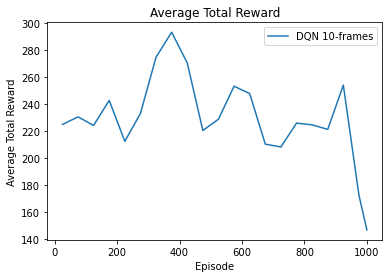

In [16]:
# Load the CSV results
df = pd.read_csv("dqn_results_10frames.csv")

# Compute averages of total rewards every 50 episodes
df["group"] = df["episode"] // 50  # Group by every 50 episodes
average_rewards = df.groupby("group")["total_reward"].mean()  # Average rewards
average_episodes = df.groupby("group")["episode"].mean()  # Midpoint for episodes

# Plot the average total rewards over grouped episodes
plt.plot(average_episodes, average_rewards, label="DQN 10-frames")
plt.xlabel("Episode")
plt.ylabel("Average Total Reward")
plt.title("Average Total Reward")
plt.legend()
plt.show()